γ=2.5 Sweep:   0%|          | 0/26 [00:00<?, ?it/s]

CSVファイル 'SNR_vs_T_gamma_2.5.csv' が生成されました。


PDFファイル 'fig_appendix_strong_damping.pdf' が生成されました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

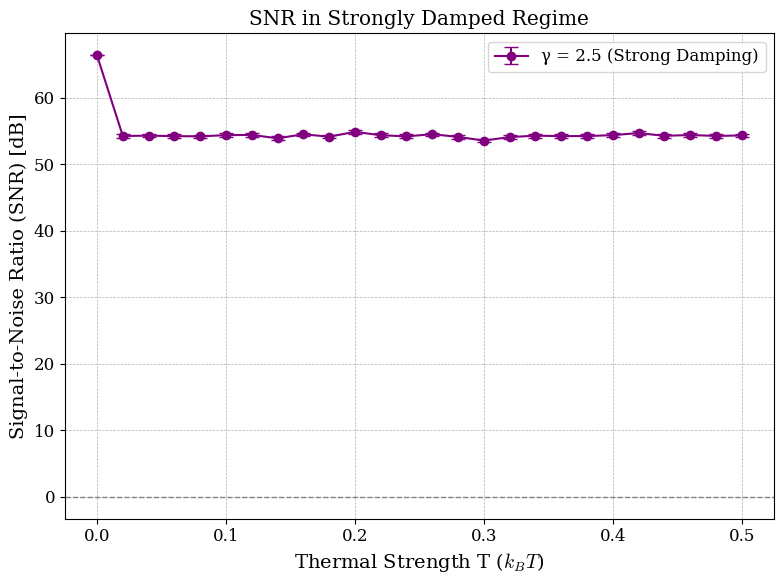

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from tqdm.notebook import tqdm
from google.colab import files

# ===================================================================
# --- グラフ品質と一貫性のための最終設定 (v5.0準拠) ---
# ===================================================================
# Adobe Acrobatでのフォント埋め込み問題を解決 (Type 42フォント)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# 論文v3, v4, v5との一貫性を保つためのフォント設定
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['mathtext.fontset'] = 'cm' # 数式フォントをComputer Modernに

# ===================================================================
# --- シミュレーションパラメータ ---
# ===================================================================
# 物理パラメータ
M = 50.0
k_mech = 10.0
gamma = 2.5  # ★★★ 今回の核心：強散逸領域に設定 ★★★
k_B = 1.0

# 時間パラメータ
dt = 0.005
T_total = 200.0
N_steps = int(T_total / dt)
t = np.linspace(0, T_total, N_steps)

# 実験パラメータ
N_runs = 100  # 統計的信頼性のためのアンサンブル数
T_values = np.linspace(0.0, 0.5, 26) # 比較のため、図2と同じ温度範囲

# 信号パラメータ (量子フィードバックを模した微弱な周期的外力)
# この信号の存在が、SRの「S」に相当する
A_signal = 0.01 # 微弱な信号振幅
f_signal = np.sqrt(k_mech / M) / (2 * np.pi) # 系の固有振動数

# ===================================================================
# --- 物理モデルとSNR計算関数 ---
# ===================================================================
def get_forces(z, v, t_val, T):
    """力を計算する関数"""
    F_restoring = -k_mech * z
    F_dissipation = -gamma * v
    F_thermal = np.sqrt(2 * gamma * k_B * T / dt) * np.random.normal(0, 1)
    F_signal_term = A_signal * np.cos(2 * np.pi * f_signal * t_val)

    F_total = F_restoring + F_dissipation + F_thermal + F_signal_term
    return F_total

def calculate_snr_welch(trajectory, dt, f_signal):
    """Welch法を用いて、より安定したSNRを計算する"""
    fs = 1.0 / dt
    nperseg = len(trajectory) // 8 # 窓長

    f, Pxx = welch(trajectory, fs, nperseg=nperseg)

    # 信号パワーの計算
    signal_idx = np.argmin(np.abs(f - f_signal))
    signal_power = Pxx[signal_idx]

    # ノイズパワーの計算 (信号ピークの近傍を除く)
    noise_indices = (np.abs(f - f_signal) > 2 * (f[1]-f[0])) & (f > 0)
    noise_power = np.mean(Pxx[noise_indices])

    if noise_power == 0: return -np.inf

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# ===================================================================
# --- シミュレーション実行 ---
# ===================================================================
results = []
for T in tqdm(T_values, desc=f"γ={gamma} Sweep"):
    snr_runs = []
    for _ in range(N_runs):
        z, v = 0.0, 0.0
        z_trajectory = np.zeros(N_steps)

        for i in range(N_steps):
            F = get_forces(z, v, t[i], T)
            a = F / M
            v += a * dt
            z += v * dt
            z_trajectory[i] = z

        # 過渡応答を除去 (後半50%のデータを使用)
        transient_steps = N_steps // 2
        snr = calculate_snr_welch(z_trajectory[transient_steps:], dt, f_signal)
        snr_runs.append(snr)

    mean_snr = np.mean(snr_runs)
    sem_snr = np.std(snr_runs) / np.sqrt(N_runs)
    results.append({'Temperature': T, 'Mean_SNR': mean_snr, 'SEM_SNR': sem_snr})

# ===================================================================
# --- データ出力とグラフ描画 ---
# ===================================================================
# CSVファイルとして保存
df_results = pd.DataFrame(results)
csv_filename = 'SNR_vs_T_gamma_2.5.csv'
df_results.to_csv(csv_filename, index=False)
print(f"CSVファイル '{csv_filename}' が生成されました。")

# グラフ描画
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(df_results['Temperature'], df_results['Mean_SNR'], yerr=df_results['SEM_SNR'],
            fmt='-o', capsize=5, color='purple', label='γ = 2.5 (Strong Damping)')

ax.set_xlabel('Thermal Strength T ($k_B T$)')
ax.set_ylabel('Signal-to-Noise Ratio (SNR) [dB]')
ax.set_title('SNR in Strongly Damped Regime')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axhline(0, ls='--', color='gray', lw=1) # 0 dB reference line
plt.tight_layout()

# PDFファイルとして保存
pdf_filename = 'fig_appendix_strong_damping.pdf'
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
print(f"PDFファイル '{pdf_filename}' が生成されました。")

# ===================================================================
# --- ファイルの自動ダウンロード ---
# ===================================================================
files.download(csv_filename)
files.download(pdf_filename)